In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# Dependencies
from pymongo import MongoClient
import pandas as pd
import numpy as np

from urls_list import * #where all urls and paths are saved

## Read the historic rental data

In [4]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsight["HistoricRental"].find({}, {'_id':0}))

In [5]:
DF = pd.DataFrame(records)

In [6]:
#Replace all white spaces or nothing at all to NaN
DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#Replace None with NaN
DF = DF.fillna(value=np.nan)

## Missing Data Analysis

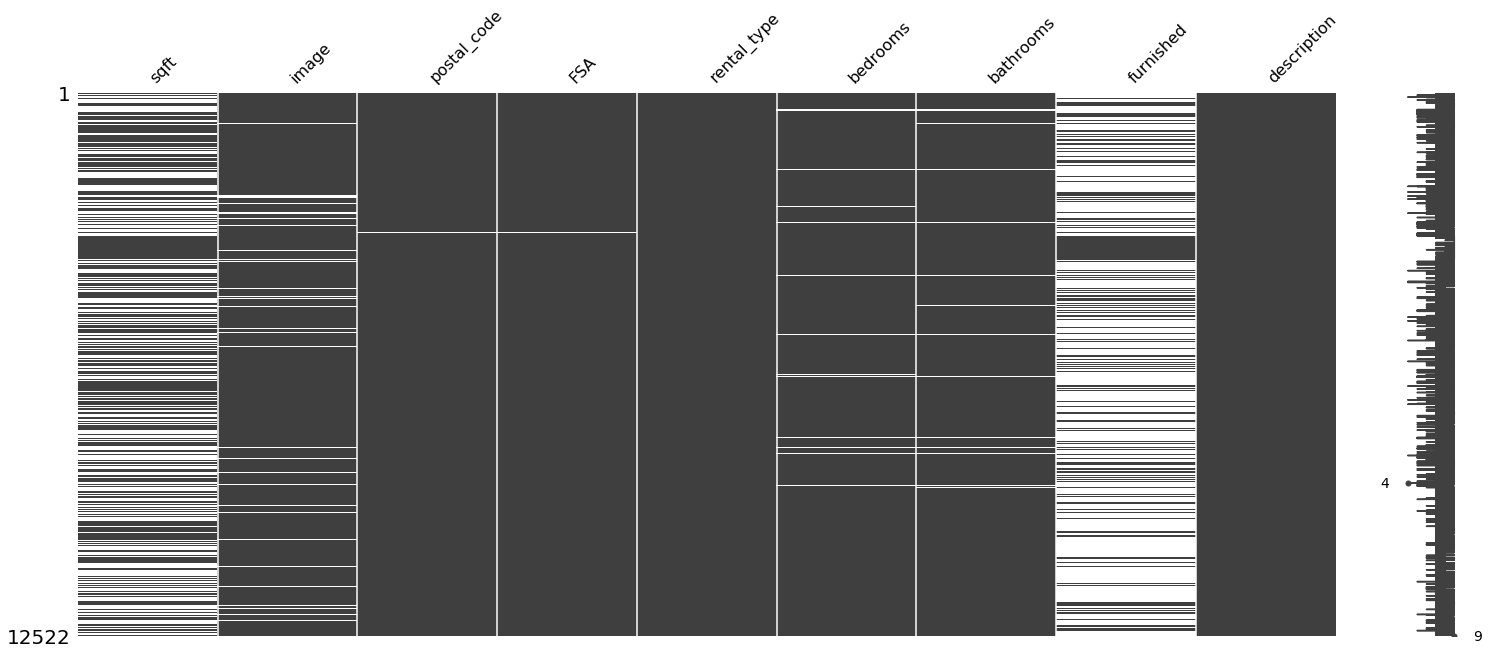

In [7]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

#### Make FSA and rental_type mandatory. If they are not retrieved in the rental posting, ML will not run, citing an exception

In [8]:
DF.drop(DF[DF[['FSA', 'rental_type']].isna().any(axis=1)].index, inplace=True)

# [1373, 3234, 3320, 3332, 3347, 3452, 3474, 3512, 3569, 3574, 3616,
#             3678, 3703, 3711, 3765, 3795, 3816, 3825, 7601, 8374, 8473, 8680,
#             9053, 9366, 9632]

In [9]:
DF = DF[DF['FSA'].str.startswith('M')]

## Type casting

In [10]:
DF['price'] = DF['price'].astype('int')

#Convert post_published_date to week of the month
from datetime import datetime
DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

#New features
DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)

## Missing value handling

In [11]:
DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
#Convert image url to image or not?
DF['image'] = DF['image'].notna()

## Removing outliers

In [12]:
#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']

#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
#DF[num_columns].quantile(0.995)
#DF[num_columns].quantile(0.005)
#DF['price'].quantile(0.995)
#DF['price'].quantile(0.005)

#Remove sqft > 3000 and less than 200
#Remove price > 10000 and less than 100

DF = DF[(DF['price']<=10000) & (DF['price']>=100)]
DF.drop(DF[(DF['sqft']<200) | (DF['sqft']>3000)].index, axis=0, inplace=True)

## Basic Transformations

In [13]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']
DF.reset_index(drop=True, inplace=True)
X = DF[num_columns + cat_columns]
Y = DF['price']


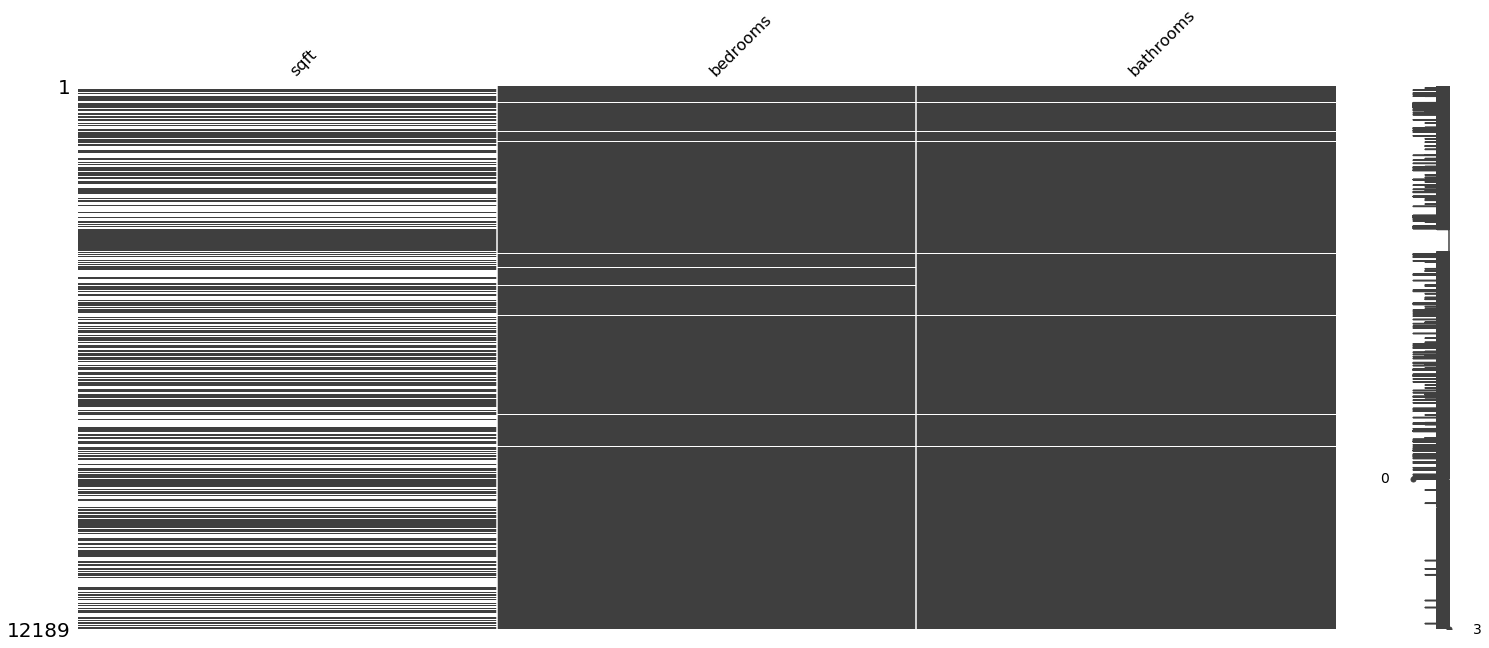

In [14]:
missingdata_col = X.columns[X.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(X[missingdata_col])

### One Hot Encoding

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
##OHE
enc = OneHotEncoder()
##OHE Fit
enc.fit(X[cat_columns])
##OHE Transform
ohe_output = enc.transform(X[cat_columns]).toarray()
##Retrieve OHE labels
ohe_dict = {f'x{index}':col for index,col in enumerate(cat_columns)}
ohe_labels = [ohe_dict[feature.split('_')[0]]+'_'+feature.split('_')[1] for feature in enc.get_feature_names()]
X = pd.concat([X, pd.DataFrame(ohe_output, columns=ohe_labels)], axis=1)
X.drop(cat_columns, axis=1, inplace=True)


OneHotEncoder()

## Train Test Split

In [16]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)


## Inference

- From the base model results, it is clear that there is overfitting.
- We need to use some feature selection methods to choose less features

In [ ]:
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

#num_features = list(range(20,len(X.columns)+1,20))
num_features = [25, 30, 35]
num_features.append(len(X.columns))
scores = []
for no in num_features:
    rfe = RFE(estimator=xgb.XGBRegressor(gamma=0.01), n_features_to_select=no, verbose=5)
    xgb_model = xgb.XGBRegressor(gamma=0.01)
    pipeline = Pipeline(steps=[('feature_selection',rfe),('model',xgb_model)])
    # evaluate model
    cv = KFold(n_splits=5)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise', verbose=5)
    # Append the scores for the "no" of features
    scores.append(n_scores)
    print(f"Finished {no} features")

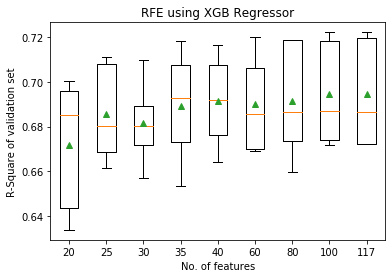

In [18]:
scores = [[0.63364091, 0.64334008, 0.68503601, 0.69585062, 0.7004957 ],
 [0.66135547, 0.68012852, 0.6684632 , 0.71124362, 0.70794003],
 [0.65692624, 0.67157828, 0.68010736, 0.68922656, 0.70980065],
 [0.65325375, 0.67292199, 0.69293267, 0.71857594, 0.70783382],
 [0.67636927, 0.66411491, 0.69194508, 0.71680965, 0.70770006],
 [0.66981596, 0.66924637, 0.68586723, 0.72016992, 0.70643464],
 [0.65981554, 0.67345238, 0.68661759, 0.71885106, 0.71895621],
 [0.67167753, 0.67400777, 0.68718622, 0.71835931, 0.72232896],
 [0.67235802, 0.67224939, 0.68649689, 0.71976075, 0.72224526]]

num_features = [20, 25, 30, 35, 40, 60, 80, 100, 117]

import matplotlib.pyplot as plt
# plot model performance for comparison
_=plt.boxplot(scores, labels=num_features, showmeans=True)
_=plt.xlabel("No. of features")
_=plt.ylabel("R-Square of validation set")
_=plt.title("RFE using XGB Regressor")
_=plt.savefig("RFE_granular.png")
_=plt.show()


# scores
# num_features

# [array([0.63364091, 0.64334008, 0.68503601, 0.69585062, 0.7004957 ]),
#  array([0.66135547, 0.68012852, 0.6684632 , 0.71124362, 0.70794003]),
#  array([0.65692624, 0.67157828, 0.68010736, 0.68922656, 0.70980065]),
#  array([0.65325375, 0.67292199, 0.69293267, 0.71857594, 0.70783382]),
#  array([0.67636927, 0.66411491, 0.69194508, 0.71680965, 0.70770006]),
#  array([0.66981596, 0.66924637, 0.68586723, 0.72016992, 0.70643464]),
#  array([0.65981554, 0.67345238, 0.68661759, 0.71885106, 0.71895621]),
#  array([0.67167753, 0.67400777, 0.68718622, 0.71835931, 0.72232896]),
#  array([0.67235802, 0.67224939, 0.68649689, 0.71976075, 0.72224526])]
# [20, 25, 30, 35, 40, 60, 80, 100, 117]

35 Looks like a good option

## Choose 35 features

In [ ]:
rfe = RFE(estimator=xgb.XGBRegressor(gamma=0.01), n_features_to_select=35, verbose=5)
rfe.fit(X_train, y_train)

In [ ]:
selected_columns = X.columns[rfe.support_]

In [22]:
top_35 = ['sqft', 'bedrooms', 'bathrooms', 'image_False', 'FSA_M1B', 'FSA_M1M',
       'FSA_M1P', 'FSA_M1V', 'FSA_M1W', 'FSA_M2M', 'FSA_M3C', 'FSA_M3K',
       'FSA_M4E', 'FSA_M4V', 'FSA_M4W', 'FSA_M5G', 'FSA_M5J', 'FSA_M5R',
       'FSA_M5S', 'FSA_M5V', 'FSA_M6B', 'FSA_M6E', 'FSA_M6G', 'FSA_M6J',
       'FSA_M6K', 'FSA_M6M', 'FSA_M6P', 'rental_type_apartment',
       'rental_type_condo', 'rental_type_house', 'rental_type_loft',
       'rental_type_townhouse', 'furnished_NOT', 'furnished_YES',
       'pet_friendly_False']

# Most important 30 features
#train_score - 0.8269937478985029, test_score - 0.6524785057215365


In [ ]:
selected_columns

In [26]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(gamma=0.01)#objective='reg:squarederror'
xgb_model.fit(X_train[top_35], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
y_pred = xgb_model.predict(X_test[top_35])

In [31]:
xgb_model.score(X_train[top_35], y_train)

0.8381257310598049

In [33]:
xgb_model.score(X_test[top_35], y_test)


0.7185195384620062

In [34]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))
# np.sqrt(np.mean((y_pred-y_test)**2))

0.7185195384620062

463.799842844735

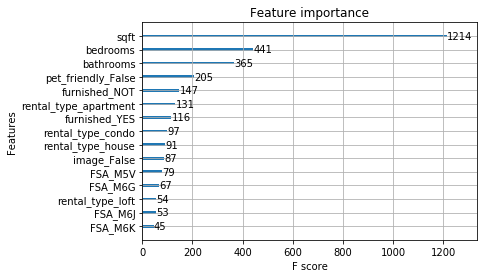

In [35]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=15) # top 15 most important features